# LANL Earthquake Prediction

The goal of this project is to use seismic signals to predict the timing of laboratory earthquakes. The data is produced by an experimental set-up used to study earthquake physics. The acoustic_data input signal is used to predict the time remaining before the next laboratory earthquake (time_to_failure). For the initial analysis, we explore the data features and decide on the best model to be used to solve this problem. Additional insight into the trends of the earthquakes can introduce better pre-processing strategies which will be taken initially to increase training time. Ensure the data are download to the same directory as this Notebook for the next data loading steps.

In [1]:
import pandas as pd

# sample submissions
sample_output = pd.read_csv('sample_submission.csv', sep=",")
sample_output.head()

,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


In [2]:
# data types for each col
print(sample_output.dtypes)

seg_id             object
time_to_failure     int64
dtype: object


## Loading and exploring train data
Column names on the train.csv file and corresponding data types:

In [11]:
from DataGen import DataGen
train_data_generator = DataGen(file_path='train.csv', chunk_size=10000000)
print(train_data_generator.col_names)
print('------------------------------------')

next_batch, end_of_file = train_data_generator.next_batch()

print('Duplicates in "time_to_failure"? {}'.format(
    not next_batch.loc[next_batch['time_to_failure'].duplicated()].empty))

next_batch.head()

['acoustic_data', 'time_to_failure']
------------------------------------
Duplicates in "time_to_failure"? False


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [2]:
# data types for each col
print(next_batch.dtypes)
print('------------------------------------')
print('Duplicates in "time_to_failure"? {}'.format(
    not next_batch.loc[next_batch['time_to_failure'].duplicated()].empty))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

acoustic_data        int64
time_to_failure    float64
dtype: object
------------------------------------
Duplicates in "time_to_failure"? False


### Plot second batch of data and zoom in

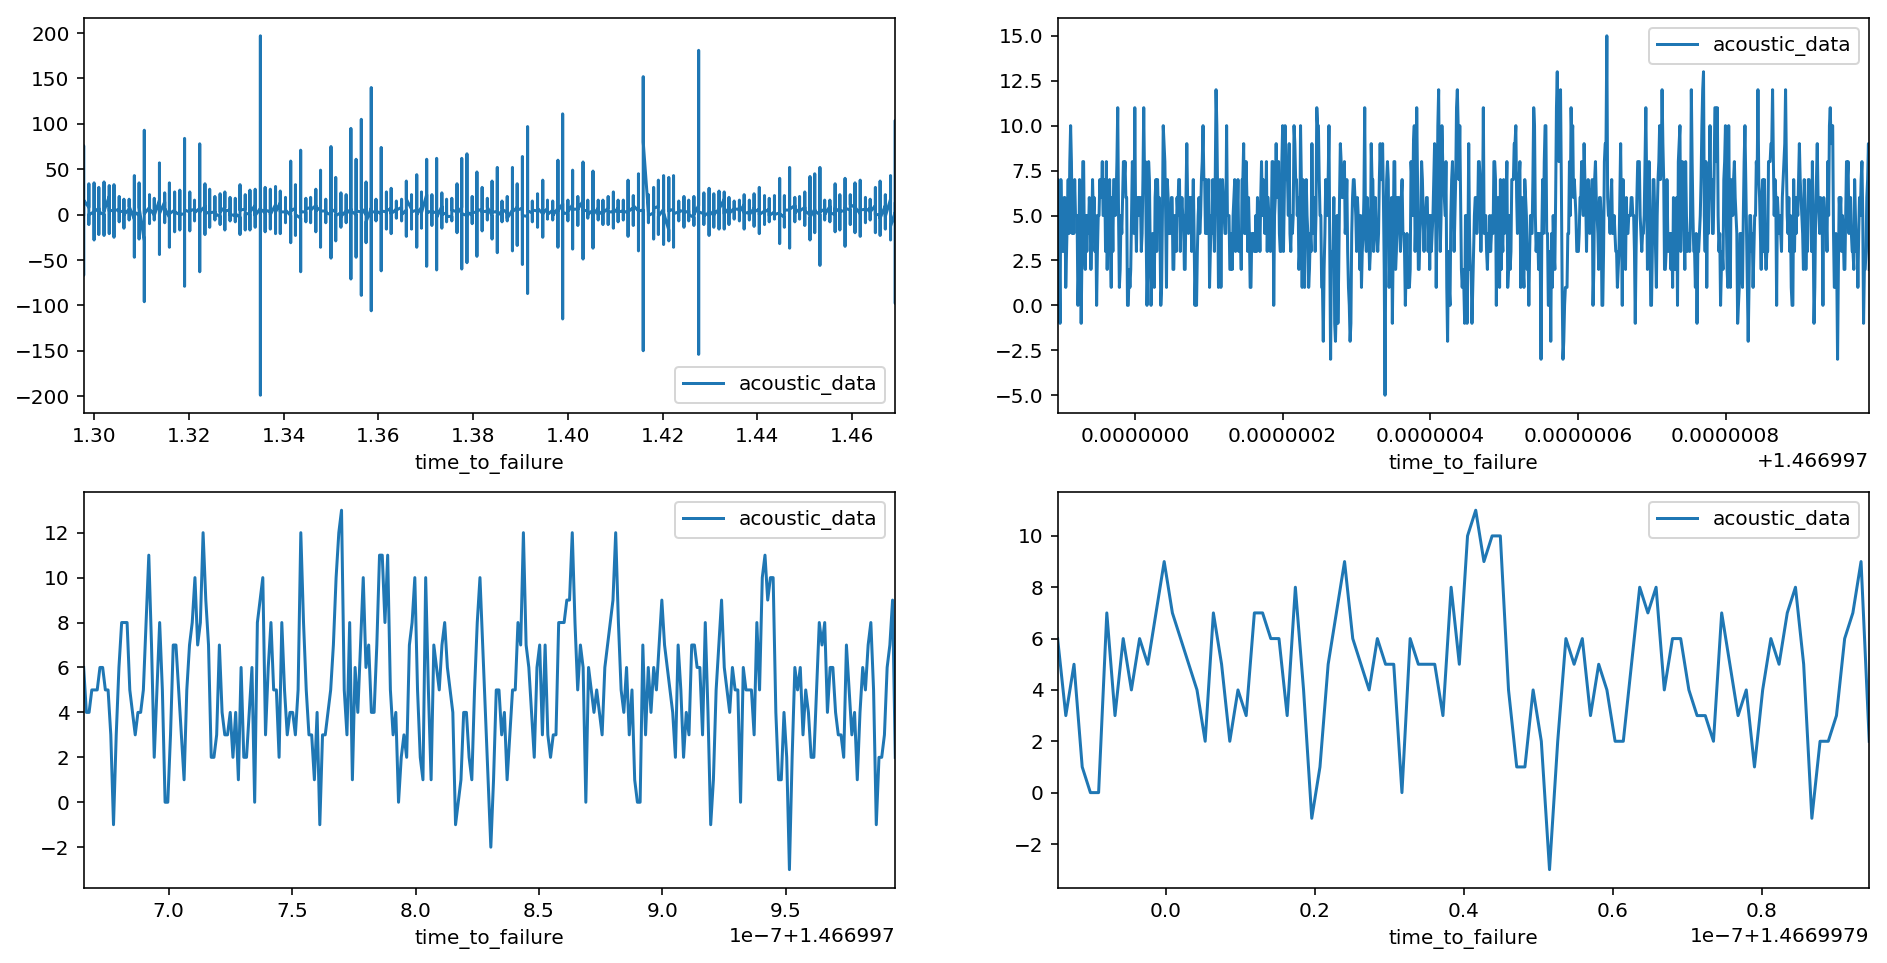

In [3]:
# plot second batch of data
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
next_batch.plot(x='time_to_failure', y='acoustic_data', ax=axs[0, 0])
next_batch[10000:11000].plot(x='time_to_failure', y='acoustic_data', ax=axs[0, 1])
next_batch[10000:10300].plot(x='time_to_failure', y='acoustic_data', ax=axs[1, 0])
next_batch[10000:10100].plot(x='time_to_failure', y='acoustic_data', ax=axs[1, 1])

We have coarse sinosoidal data as acoustic_data with a good small integer range but since it is 64 bit int, it can be further optimized if min/max values are found. The time data is very coarse float type and can further be rescaled to optimized integers for more efficient computations. Initially the data will be condensed for more optimized computations using fourier decomposition of the sinosoidal data.

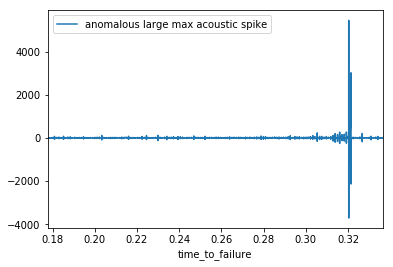

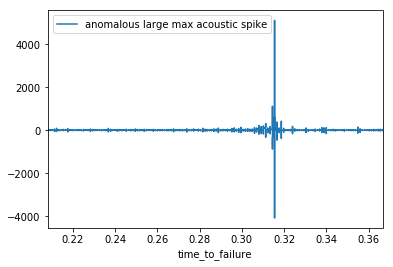

In [16]:
if next_batch.empty:
    train_data_generator = DataGen(file_path='train.csv', chunk_size=10000000)
    next_batch, end_of_file = train_data_generator.next_batch()

maxx = next_batch.max(axis=0)
minn = next_batch.min(axis=0)
summ = next_batch.sum(axis=0)
max_acoustic = maxx[0]
sum_acoustic = summ[0]
min_acoustic = minn[0]
max_time = maxx[1]
sum_time = summ[1]
min_time = minn[1]
data_points = next_batch.shape[0]
while True:
    maxx = next_batch.max(axis=0)
    minn = next_batch.min(axis=0)
    if maxx[0] > 5000.0:
        next_batch.plot(x='time_to_failure', y='acoustic_data', label='anomalous large max acoustic spike')
    if maxx[0] > max_acoustic:
        max_acoustic = maxx[0]
    if minn[0] < min_acoustic:
        min_acoustic = minn[0]
    if maxx[1] > max_time:
        max_time = maxx[1]
    if minn[1] < min_time:
        min_time = minn[1]

    next_batch, end_of_file = train_data_generator.next_batch()
    if end_of_file:
        break
    data_points += next_batch.shape[0]
    summ = next_batch.sum(axis=0)
    sum_acoustic += summ[0]
    sum_time += summ[1]

In [17]:
{
    'max_acoustic': max_acoustic, 'min_acoustic': min_acoustic, 'max_time': max_time, 'min_time': min_time,
    'avg_acoustic': sum_acoustic / data_points, 'ave_time': sum_time / data_points
}

{'max_acoustic': 5444.0,
 'min_acoustic': -5515.0,
 'max_time': 16.1074,
 'min_time': 9.550396316600001e-05,
 'avg_acoustic': 4.519467573700124,
 'ave_time': 5.678291712978873}

# Data Extremeties
There appears to be big spikes that could be important for predicting the time of event, the ultimate prediction for this project.